# Example use of DynO - 3D domain

## Imports

In [1]:
from dyno import DynO #imported from dyno.py

### Imports needed only to claculate objective function
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import Bounds, differential_evolution

import matplotlib.pyplot as plt

## Reactive system

A reactive system made of two reactions $A+B\rightarrow C$ and $C+B\rightarrow D$ is considered. The objective to be optimized is the yield of species $C$ w.r.t. the limiting reagent $A$ divided by the total numer of reagent equivalents. The true objective is tainted with i.i.d. noise.

In [2]:
def k_rxn(T):
    k0 = np.array([4., 5.]) #[m3/kmol/s]
    Ea_R = np.array([2300., 2600.]) #[K] Ea/R
    
    return k0*np.exp(-Ea_R/T)

def ReactiveSys(trxn, c0, T=298.15, plot=False):
    #t [min], c0 [kmol/m3], T[K]
    
    species = ['A', 'B', 'C', 'D']
    nu = np.array([[-1, -1, 1, 0], #A+B->C
                   [0, -1, -1, 1], #C+B->D
                  ])
    alpha = (nu<0)*1
    krxn = k_rxn(T)
    
    sol = solve_ivp(lambda t,y: (krxn*np.prod(y**alpha,1)).dot(nu), [0, trxn*60], c0, method='LSODA')
    t = sol.t/60 #[min]
    c = sol.y.T
    
    XA = 1-c[:,0]/c0[0]
    YC_A = c[:,2]/c0[0]
    
    if plot:
        plt.plot(t,YC_A/(1+c0[1]/c0[0]))
        plt.xlabel('Time [min]')
        plt.ylabel('Yield / Reag. equiv.')
        plt.show()

    return YC_A[-1]/(1+c0[1]/c0[0])

def Objective(trxn, c0, T=298.15):
    return ReactiveSys(trxn, c0, T)+np.random.normal(0,.001)

## Optimization

The optimization domain is 2D:
- Residence time [5, 30] min
- Ratio of concentration between species $B$ and $A$ in [1.5, 3]
- Temperature [0, 40] °C

TThe inlet concentration of $A$ is assumed to be 1 M.

In [3]:
domain = np.array([[5, 30], #[min] res. time
                   [1.5, 3], #B equiv.
                   [273.15, 313.15] #[K] temp.
                  ])
dtS = 10. #[min] sampling time

The true optimum is evaluated considering the noisless objective:

Optimum location: 30.00 min, 1.50 equiv. of B, 0.04 °C temp.; optimum value: 0.213


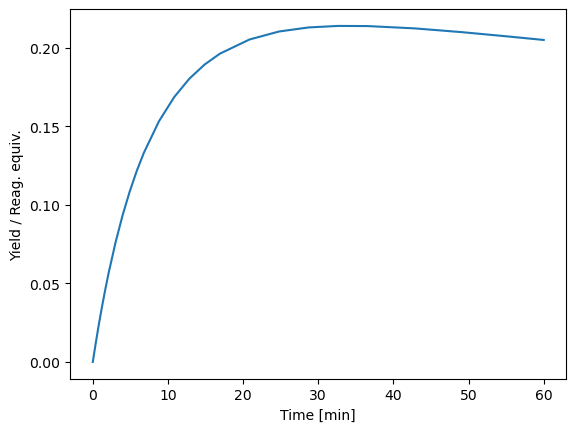

In [4]:
bnd = Bounds(lb=domain[:,0], ub=domain[:,1])

TrueOpt = differential_evolution(lambda pars: -ReactiveSys(pars[0], np.array([1., pars[1], 0, 0]), pars[2]), bnd)

print('Optimum location: %0.2f min, %0.2f equiv. of B, %0.2f °C temp.; optimum value: %0.3f' % (TrueOpt.x[0], TrueOpt.x[1], TrueOpt.x[2]-273.15, -TrueOpt.fun))
_ = ReactiveSys(2*TrueOpt.x[0], np.array([1.,TrueOpt.x[1],0.,0.]), TrueOpt.x[2], True)

### Initialization

DynO is initialized with minimal settings:

In [5]:
opt = DynO(['Res. time [min]', '[B]_0/[A]_0', 'Temp. [K]'],
           domain,
           dtSampling=dtS,
           KXmax=[.4, .4, .09],
           IntegralSample=[False, False, True]
          )

A dynamic initilization experiment is generated by DynO using Lissajous curves:

In [6]:
X0, delta, period, phase, texp, NS, tSampl, XSampl = opt.SuggestInit()

delta/Kmax
   Res. time [min]: 1.79
   [B]_0/[A]_0: 0.83
   Temp. [K]: 0.76
Period ratio = 2
Initialization will take 14.04 h.


The objective is evaluated. In real scenarios this would be the experimental part.

In [7]:
ObjSampl = np.zeros(NS)
for ii in range(NS):
    c0 = np.array([1., XSampl[ii,1], 0, 0])
    ObjSampl[ii] = Objective(XSampl[ii,0],c0,XSampl[ii,2])

The collected data is added to the data pool:

In [8]:
opt.AddResults(tSampl, XSampl, ObjSampl)

Results are displayed:

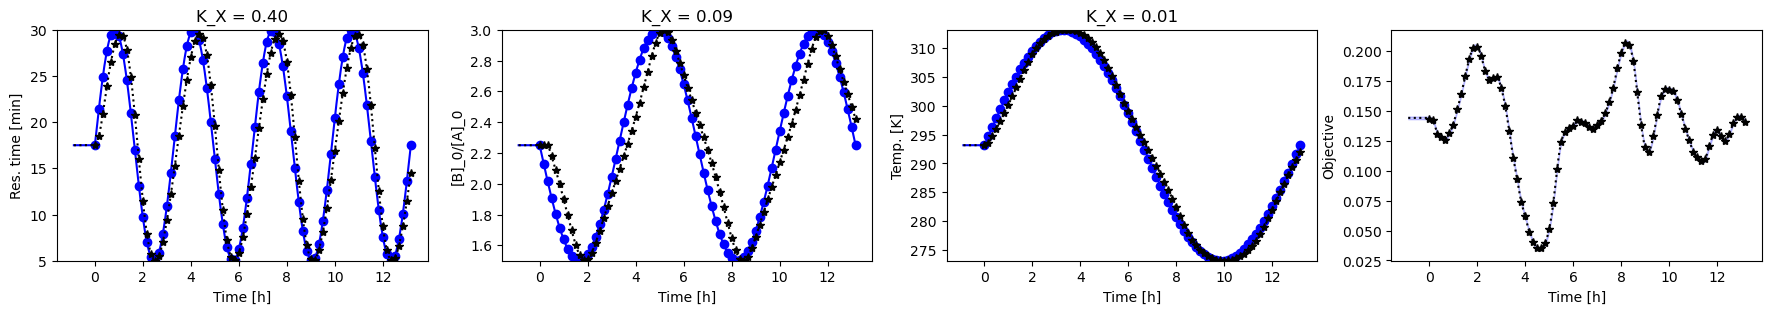

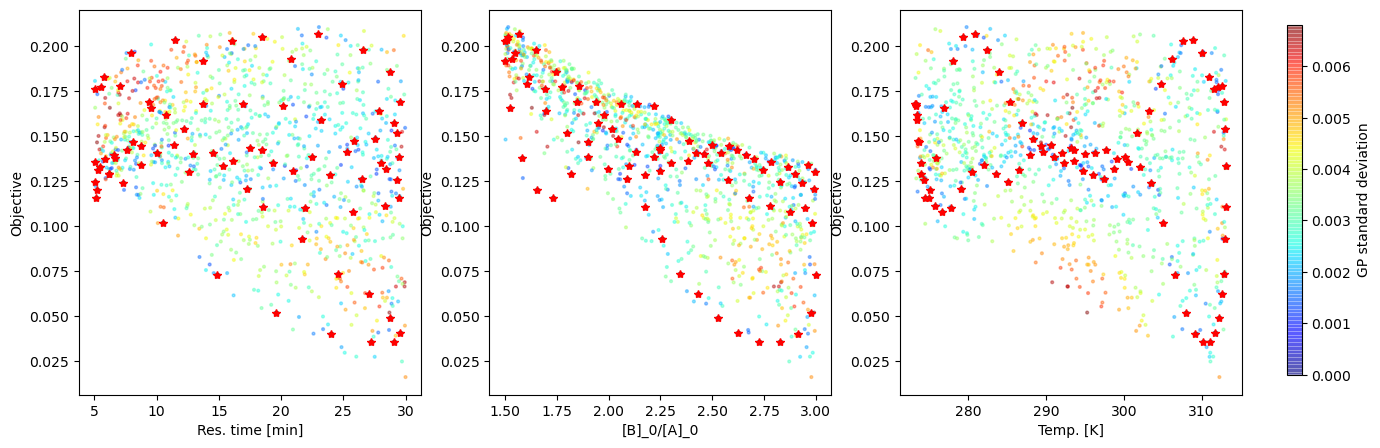

Current optima: 0.21 measured at [ 22.96   1.57 280.84] | 0.21±0.01 estimated at [ 27.51   1.5  273.15]
Distance/repulsion range: 0.41 - 1.90


In [9]:
opt.PlotTrajectory()

### Iteration 1

A new trajectory is computed by DynO:

In [10]:
X0, delta, period, phase, texp, NS, tSampl, XSampl = opt.CalculateNewTrajectory()

Creating a new trajectory (based on iterations up to 1).


The objective is evaluated (the experiment is performed) and results are added to the data pool:

In [11]:
ObjSampl = np.zeros(NS)
for ii in range(NS):
    c0 = np.array([1., XSampl[ii,1], 0, 0])
    ObjSampl[ii] = Objective(XSampl[ii,0],c0,XSampl[ii,2])

opt.AddResults(tSampl, XSampl, ObjSampl)

Results are displayed:

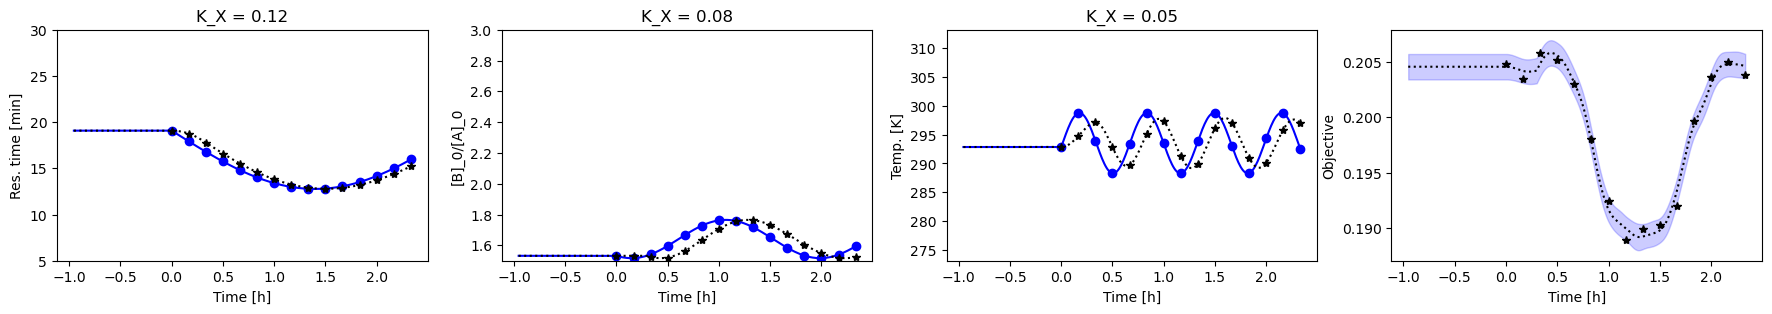

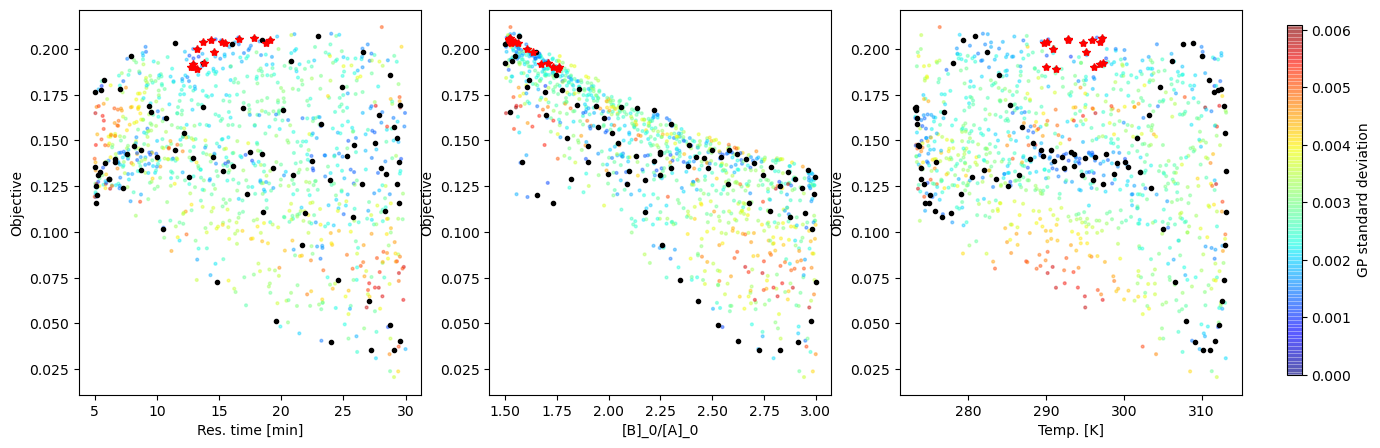

Current optima: 0.21 measured at [ 22.96   1.57 280.84] | 0.22±0.01 estimated at [ 27.46   1.5  273.15]
Distance/repulsion range: 0.37 - 0.93


In [12]:
opt.PlotTrajectory()

Convergence criteria are checked (with a possible estimate of regret) and the current actual regret is calculated:

In [13]:
opt.CheckConvergence()

print('Actual regret (exp.): %0.1f%%' % ((1-ReactiveSys(opt.best_X_hist[-1,0], np.array([1., opt.best_X_hist[-1,1], 0, 0]), opt.best_X_hist[-1,2])/(-TrueOpt.fun))*100,))
print('Actual regret (est.): %0.1f%%' % ((1-ReactiveSys(opt.best_X_estim_hist[-1,0], np.array([1., opt.best_X_estim_hist[-1,1], 0, 0]), opt.best_X_estim_hist[-1,2])/(-TrueOpt.fun))*100,))

Convergence checks:
	 Measured and estimated objectives have similar value (10% significance level)... Passed.
	 Measured and estimated objectives are close in the design space (< 0.100)... Failed.
		 Best location: [ 22.96   1.57 280.84] measured | [ 27.46   1.5  273.15] estimated
	 Estimated objective value has low uncertainty (sigma-sigma_n < 5%)... Passed.
	 Estimated objective location has not moved significantly (< 0.100)... Passed.

1i3c criterion satisfied at iteration 2. Regret estimate < 2%
Actual regret (exp.): 3.5%
Actual regret (est.): 0.5%


### Iteration 2

A new trajectory is computed by DynO:

In [14]:
X0, delta, period, phase, texp, NS, tSampl, XSampl = opt.CalculateNewTrajectory()

Creating a new trajectory (based on iterations up to 2).


The objective is evaluated (the experiment is performed) and results are added to the data pool:

In [15]:
ObjSampl = np.zeros(NS)
for ii in range(NS):
    c0 = np.array([1., XSampl[ii,1], 0, 0])
    ObjSampl[ii] = Objective(XSampl[ii,0],c0,XSampl[ii,2])

opt.AddResults(tSampl, XSampl, ObjSampl)

Results are displayed:

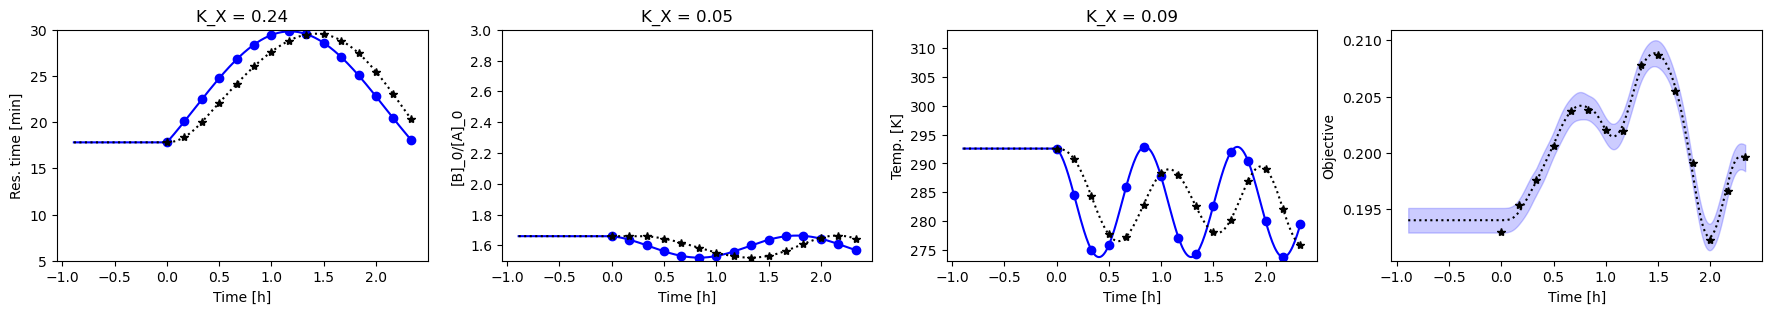

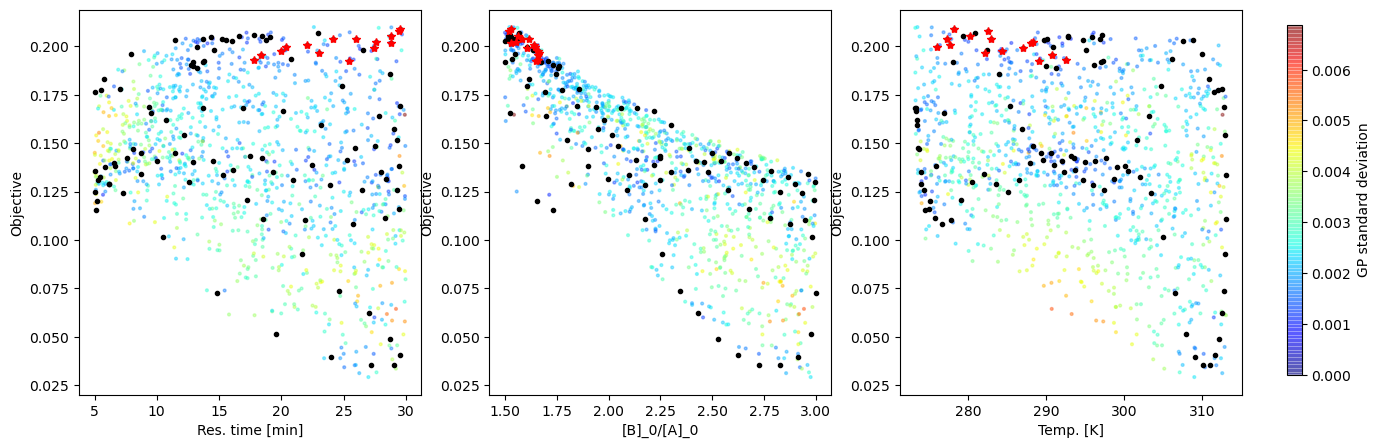

Current optima: 0.21 measured at [ 29.5    1.53 278.12] | 0.21±0.01 estimated at [ 27.     1.5  273.15]
Distance/repulsion range: 0.52 - 1.39


In [16]:
opt.PlotTrajectory()

Convergence criteria are checked (with a possible estimate of regret) and the current actual regret is calculated:

In [17]:
opt.CheckConvergence()

print('Actual regret (exp.): %0.1f%%' % ((1-ReactiveSys(opt.best_X_hist[-1,0], np.array([1., opt.best_X_hist[-1,1], 0, 0]), opt.best_X_hist[-1,2])/(-TrueOpt.fun))*100,))
print('Actual regret (est.): %0.1f%%' % ((1-ReactiveSys(opt.best_X_estim_hist[-1,0], np.array([1., opt.best_X_estim_hist[-1,1], 0, 0]), opt.best_X_estim_hist[-1,2])/(-TrueOpt.fun))*100,))

Convergence checks:
	 Measured and estimated objectives have similar value (10% significance level)... Failed.
		 Best value: 0.21 measured | 0.21 estimated
	 Measured and estimated objectives are close in the design space (< 0.100)... Failed.
		 Best location: [ 29.5    1.53 278.12] measured | [ 27.     1.5  273.15] estimated
	 Estimated objective value has low uncertainty (sigma-sigma_n < 5%)... Passed.
	 Estimated objective location has not moved significantly (< 0.100)... Passed.

2i2c criterion satisfied at iteration 3. Regret estimate < 2.5%
Actual regret (exp.): 1.7%
Actual regret (est.): 0.6%
